(0.0, 20.0)

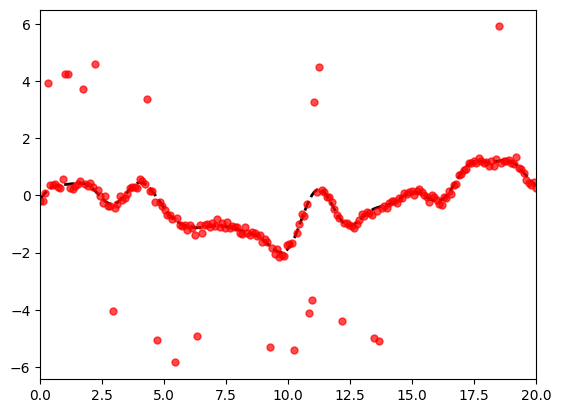

In [2]:
from typing import Optional

import tensorflow as tf
import numpy as np
from check_shapes import check_shapes, inherit_check_shapes
from typing import Optional, Tuple, Type, Union, cast
import tensorflow_probability as tfp
import gpflow

from gpflow.base import InputData, MeanAndVariance, RegressionData, TensorData
from gpflow.kernels import Kernel
from gpflow.likelihoods import Gaussian
from gpflow.mean_functions import MeanFunction
from gpflow.models.model import GPModel
from gpflow.models.training_mixins import InternalDataTrainingLossMixin
from gpflow.models.util import data_input_to_tensor
from gpflow.config import default_float, default_jitter
from gpflow.utilities import to_default_float
from gpflow import posteriors
from gpflow.utilities.ops import eye
import random
import w 
import tensorflow as tf
import numpy as np
import gpflow

import matplotlib.pyplot as plt
tf.keras.config.set_floatx('float64')
seed = 10

#set seed
np.random.seed(seed)
tf.random.set_seed(seed)

#create X
n_points = 200
sigma_n = 0.1
#percentage of points in x which are biased
percent_miss=0.1


#
lengthscale = 1
variance = 1

variance_out = 2

kernel=gpflow.kernels.SquaredExponential(lengthscales=lengthscale, variance=variance)

x = np.linspace(0, 20, n_points).reshape(n_points, 1)
f = np.random.multivariate_normal(mean=np.zeros(len(x)) ,cov=kernel(x, x)).reshape(n_points, 1)

i_obs = np.random.choice(
    np.arange(0, n_points, 1), int( n_points), replace=False)

y_obs = f[i_obs] + np.random.normal(scale=sigma_n, size=n_points).reshape(n_points, 1)
x_obs = x[i_obs]

arr1inds = x_obs[:,0].argsort()
x_obs = x_obs[arr1inds]
y_obs = y_obs[arr1inds]

i_mis = np.random.choice(
    np.arange(0, n_points, 1), int(percent_miss * n_points), replace=False)

y_mis_pos = y_obs[i_mis[(y_obs[i_mis]>0)[:,0]]]  + np.random.uniform(3, 5, size=len(i_mis[(y_obs[i_mis]>0)[:,0]])).reshape(len(i_mis[(y_obs[i_mis]>0)[:,0]]),1)
y_mis_neg = y_obs[i_mis[(y_obs[i_mis]<=0)[:,0]]]  - np.random.uniform(3, 5, size=len(i_mis[(y_obs[i_mis]<=0)[:,0]])).reshape(len(i_mis[(y_obs[i_mis]<=0)[:,0]]),1)
y_obs[i_mis[(y_obs[i_mis]>0)[:,0]]] = y_mis_pos
y_obs[i_mis[(y_obs[i_mis]<=0)[:,0]]] = y_mis_neg
X=x
y=y_obs

plt.plot(x, f, color='black', ls='--', lw=2)
plt.plot(x_obs, y_obs, 'r.', ms=10, alpha=0.7)
plt.xlim(x[0], x[-1])

In [3]:
def update_mu_f(alpha, Sigma_a_inv, J_w_inv, sigma_2, Y_train, mu_w):
    q1 = tf.linalg.inv(alpha * Sigma_a_inv + 2 * J_w_inv / sigma_2)
    q2 = tf.matmul((2 * J_w_inv / sigma_2), (Y_train - mu_w))
    return tf.matmul(q1, q2)


def update_Sigma_f(c_f, K, sigma_2, J_w):
    """
    Compute the updated value of Sigma_f.

    Parameters:
        c_f (float): Scaling constant.
        K (Tensor): Kernel matrix.
        sigma_2 (float): Noise variance.
        J_w (Tensor): Weight matrix.

    Returns:
        Tensor: The updated value of Sigma_f.
    """
    Sigma_f = c_f * K * tf.linalg.inv(K + sigma_2 * J_w / 2) * sigma_2 * J_w / 2
    return Sigma_f


def divide_batch(X, y, test_ratio=0.2, seed=None):
    if seed is None:
        seed = np.random.uniform(0, 1000)

    random.seed(seed)

    # Get the number of samples
    n = tf.shape(X)[0]
    num_test = tf.cast(tf.math.round(test_ratio * tf.cast(n, tf.float32)), tf.int32)

    # Shuffle indices
    indices = tf.range(n)
    shuffled_indices = tf.random.shuffle(indices)

    # Split indices
    test_indices = shuffled_indices[:num_test]
    train_indices = shuffled_indices[num_test:]

    # Split data
    X_train = tf.gather(X, train_indices)
    X_test = tf.gather(X, test_indices)
    Y_train = tf.gather(y, train_indices)
    Y_test = tf.gather(y, test_indices)
    return X_train, Y_train, X_test, Y_test, train_indices, test_indices


def maximize_c(y, quant):
    return np.quantile(abs(y), 1 - quant)


def Full_sample_estimate(variance, lengthscale, X, w_full, c_f, alpha, Y):
    kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(variance, lengthscale)
    K = kernel.matrix(X, X)
    #update quantitites, Sigma_a,J_w
    w_full = sigma / (2 ** 0.5) * w_full
    J_w = tf.linalg.tensor_diag(tf.squeeze(tf.math.pow(w_full, -2))) * sigma ** 2 / 2
    J_w_inv = tf.linalg.tensor_diag(tf.squeeze(tf.math.pow(w_full, 2))) * 2 / (sigma ** 2)

    Sigma_f = (c_f * K @ tf.linalg.inv(K + sigma ** 2 / 2 * J_w) * sigma ** 2 / 2) @ J_w

    Sigma_a = alpha * K + (1 - alpha) * Sigma_f
    Sigma_a_inv = tf.linalg.inv(Sigma_a)

    mu_f = update_mu_f(alpha, Sigma_a_inv, J_w_inv, sigma ** 2, Y, m_w_full)
    return (mu_f, Sigma_f)



import random
c = maximize_c(y, 0.1)

W = IMQ(c)
w_full = tf.cast(W.W(X, y), dtype=tf.float64)
m_w_full = W.dy(X, y) ** 2
@tf.function
def add_noise_cov(K: tf.Tensor, W: tf.Tensor, likelihood_variance) -> tf.Tensor:
    k_diag = tf.linalg.diag_part(K)
    return tf.linalg.set_diag(K, k_diag + likelihood_variance * (W ** -2))


@tf.function
def loo_cv(X, y, mean_function, kernel, W, noise_variance, likelihood) -> tf.Tensor:
    r"""
    Computes the leave one out to train the model
    """
    err = y - tf.reshape(mean_function(X), (-1, 1))
    K = kernel.matrix(X, X)
    n = tf.cast(tf.shape(X)[0], K.dtype)

    likelihood_variance = likelihood.variance_at(X)  #####WHAT IS THIS???
    W = IMQ(c)

    W, W_dy = W.w_dy(X, err)
    dylog2 = 2 * likelihood_variance * W_dy / W
    Y_bar = err - dylog2

    K_sW = add_noise_cov(K, tf.squeeze(W, axis=-1), tf.squeeze(likelihood_variance, axis=-1))
    L_sW = tf.linalg.cholesky(K_sW)
    L_sW_inv = tf.linalg.inv(L_sW)

    #K_sW_inv = tf.linalg.matmul(L_sW_inv, L_sW_inv, transpose_a=True)

    #diag_K_sW_inv = tf.reshape(tf.linalg.diag_pxart(K_sW_inv), (-1, 1))
    diag_K_sW_inv = tf.reshape(tf.reduce_sum(L_sW_inv ** 2, axis=0), (-1, 1))

    A = diag_K_sW_inv * dylog2

    #B = tf.matmul(K_sW_inv, Y_bar)
    B = tf.matmul(L_sW_inv, tf.matmul(L_sW_inv, Y_bar), transpose_a=True)
    C = diag_K_sW_inv * (1 - diag_K_sW_inv * (likelihood_variance * (W ** -2) - likelihood_variance))

    D = C / diag_K_sW_inv ** 2

    loo = - 0.5 * tf.reduce_sum(tf.math.log(D))
    loo -= 0.5 * n * np.log(2 * np.pi)
    loo -= 0.5 * tf.reduce_sum((A + B) ** 2 / C)
    return loo


sigma = tf.Variable(0.01, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
c_f = tf.Variable(1., dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
variance = tf.Variable(4.5, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
lengthscale = tf.Variable(.9, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
alpha = tf.Variable(0.5, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, -1, 2))


def mean_function(X):
    return tf.zeros(tf.shape(X)[0], dtype=tf.float64)


import tensorflow_probability as tfp

for i in range(500):
    print(i)
    with tf.GradientTape(persistent=True) as tape:
        #create batch for the iteration
        X_train, Y_train, X_test, Y_test, train_indices, test_indices = divide_batch(X, y, test_ratio=0.2, seed=1)
        n_test = X_test.shape[0]
        #estimate Gpflow kernel.
        kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(variance, lengthscale)
        K = kernel.matrix(X_train, X_train)

        new_ind = list(train_indices.numpy())
        #update quantitites, Sigma_a,J_w
        w_train = tf.gather(w_full, train_indices)
        m_w = tf.gather(m_w_full, train_indices)
        J_w = tf.linalg.tensor_diag(tf.squeeze(tf.math.pow(w_train, -2)))
        J_w_inv = tf.linalg.tensor_diag(tf.squeeze(tf.math.pow(w_train, 2)))

        Sigma_f = (c_f * K @ tf.linalg.inv(K + sigma ** 2 / 2 * J_w) * sigma ** 2 / 2) @ J_w

        Sigma_a = alpha * K + (1 - alpha) * Sigma_f
        Sigma_a_inv = tf.linalg.inv(Sigma_a)

        mu_f = update_mu_f(alpha, Sigma_a_inv, J_w_inv, sigma ** 2, Y_train, m_w)
        K_star = tf.transpose(kernel.matrix(X_test, X_train))
        K_star_star = kernel.matrix(X_test, X_test)

        mu_f_pred = tf.transpose(K_star) @ tf.linalg.inv(K) @ mu_f
        sigma_f_pred = K_star_star
        sigma_f_pred = sigma_f_pred - c_f * tf.transpose(K_star) @ tf.linalg.inv(K + sigma ** 2 * J_w) @ K_star
        sigma_f_pred = sigma_f_pred + (c_f - 1) * tf.transpose(K_star) @ tf.linalg.inv(K) @ K_star + tf.linalg.eye(
            n_test, dtype=tf.float64) * sigma**2
        sigma_f_pred=tf.linalg.diag_part(sigma_f_pred)#*tf.gather(w_full, test_indices)**(-2)
        vv = tfp.distributions.Normal(mu_f_pred, sigma_f_pred)
        loss = vv.log_prob(Y_test)

        """
        Computes the leave one out to train the model
        """

        """
             err = y -tf.reshape(mean_function(X), (-1, 1))
        K = kernel.matrix(X,X)
        n = tf.cast(tf.shape(X)[0], K.dtype)
        
        likelihood_variance = likelihood.variance_at(X) #####WHAT IS THIS???
        W=IMQ(c)
        W,W_dy=W.w_dy(X,err)
        dylog2 = 2*likelihood_variance*W_dy/W
        Y_bar = err - dylog2
        
        K_sW = add_noise_cov(K, tf.squeeze(W, axis=-1), tf.squeeze(likelihood_variance, axis=-1))
        L_sW = tf.linalg.cholesky(K_sW)
        L_sW_inv = tf.linalg.inv(L_sW)

        #K_sW_inv = tf.linalg.matmul(L_sW_inv, L_sW_inv, transpose_a=True)

        #diag_K_sW_inv = tf.reshape(tf.linalg.diag_pxart(K_sW_inv), (-1, 1))
        diag_K_sW_inv = tf.reshape(tf.reduce_sum(L_sW_inv**2, axis=0), (-1, 1))

        A = diag_K_sW_inv*dylog2
        
        #B = tf.matmul(K_sW_inv, Y_bar)
        B = tf.matmul(L_sW_inv, tf.matmul(L_sW_inv, Y_bar), transpose_a=True)
        C = diag_K_sW_inv * (1-diag_K_sW_inv*(likelihood_variance*(W**-2) - likelihood_variance))

        D = C/diag_K_sW_inv**2

        loss = - 0.5 * tf.reduce_sum(tf.math.log(D))
        loss -= 0.5 * n * np.log(2 * np.pi)
        loss -= 0.5 * tf.reduce_sum((A+B)**2/C)
        
        """
    grad = tape.gradient(loss, [c_f, sigma, variance, lengthscale, alpha])
    optimizer = tf.optimizers.Adam()
    optimizer.apply_gradients(zip(grad, [c_f, sigma, variance, lengthscale, alpha]))

Mu_full, Sigma_full1 = Full_sample_estimate(variance, lengthscale, X, w_full, c_f, alpha, y)

NameError: name 'IMQ' is not defined